## Notebook to illustrate the application of the probablistic jerk finder to multiple jerks.

#### Here is an assumed underlying piecewise linear time dependence with a change in slope at t=20, t=50 and t=75.


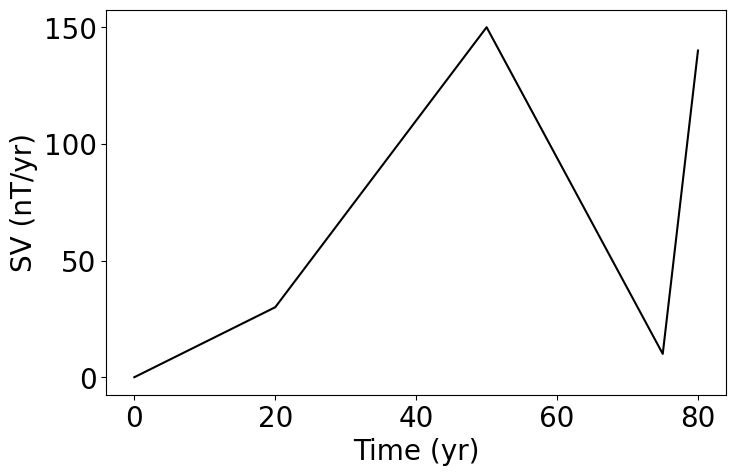

In [3]:
import matplotlib.pyplot as plt
import numpy as np
time_for_plotting = np.linspace(0,80,100,endpoint=True)
t,y = [0,20,50,75,80],[0,30,150,10,140]
fig, ax = plt.subplots( figsize=(8,5))
ax.plot(t,y,'k');
ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('SV (nT/yr)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example2_raw_signal.pdf',bbox_inches='tight')

In [6]:
slope = np.zeros(4)
for i in range(4):
    slope[i] = (y[i+1]-y[i])/(t[i+1]-t[i]) 
for i in range(3):
    print('Changes in slope are : ', slope[i+1]-slope[i] )

Changes in slope are :  2.5
Changes in slope are :  -9.6
Changes in slope are :  31.6


#### Now we sample the timeseries at NUM_DATA points (here, assumed equally spaced) and add noise (assumed normally distributed with known standard deviation)

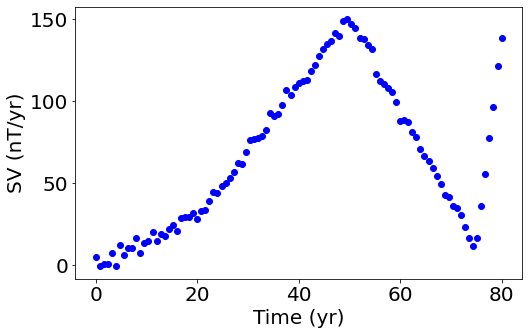

In [2]:
fig, ax = plt.subplots( figsize=(8,5))
np.random.seed(seed = 1)
NUM_DATA = 101
TIMES = np.linspace(0,80,NUM_DATA,dtype=float)
delta_Y = 3 * np.ones(NUM_DATA)
Y = np.interp(TIMES,[0,20,50,75,80],[0,30,150,10,140]) + np.random.normal(loc=0,scale=delta_Y)
plt.plot(TIMES, Y,'ob');
ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('SV (nT/yr)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example2_noised_signal.pdf',bbox_inches='tight')

In [3]:
import os
import sys
sys.path.append( os.path.abspath('..') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = Y.min()
Y_MAX = Y.max()

discretise_size = 100

TIMES_MIN = 0.0
TIMES_MAX = 80.0
K_MIN = 0
K_MAX = 100

sigmas = np.array([ 3,1,3],dtype = float)


THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX-K_MIN+1, dtype=int)
# jerks:
jerk_data = np.zeros( (K_MAX *(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

#saved history for animations
jerk_history = np.zeros( ((NSAMPLE-burn_in)//THIN,2), dtype=int)
model_history = np.zeros( (discretise_size, (NSAMPLE-burn_in)//THIN),dtype=float)

(Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, 
MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data, \
model_history, jerk_history) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size, 
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)


print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)


Acceptance rates should ideally be 10-40%
[31.50399971 18.85860252  4.19664192  4.20950222]


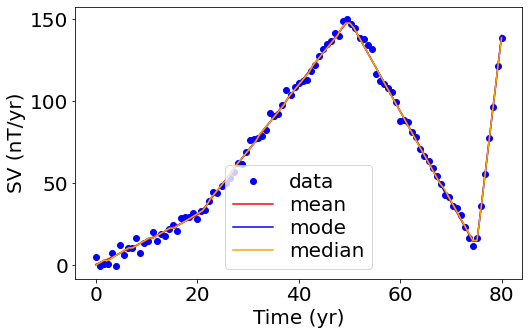

In [4]:
fig, ax = plt.subplots( figsize=(8,5))
ax.plot(TIMES,Y,'bo', label='data')
ax.plot(time_for_plotting,AV,'r', label='mean')
ax.plot(time_for_plotting,MODE, 'b',  label='mode')
ax.plot(time_for_plotting,MEDIAN, 'orange',  label='median')
#plt.plot(time_for_plotting, SUP,'k--',  label='95% credible upper bound')
#plt.plot(time_for_plotting,INF, 'k--',  label='95% credible lower bound')
ax.legend(loc='lower center',fontsize=20, labelspacing=0.2)
ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('SV (nT/yr)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('example2_posterior.pdf',bbox_inches='tight')

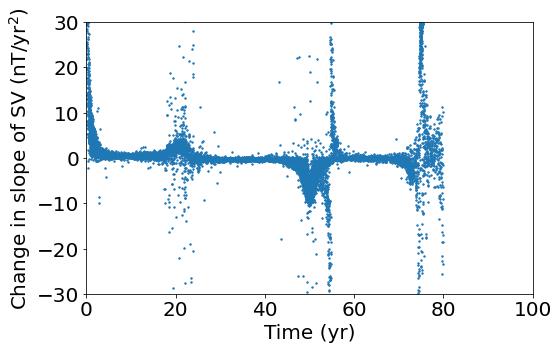

In [5]:
import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(8,5))
ax.scatter(jerk_data[0:size_jerk_data,0], jerk_data[0:size_jerk_data,1],s=2)
ax.set_xlim(0,100)
ax.set_ylim(-30,30)

ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('Change in slope of SV (nT/yr$^2$)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example2_scatter.pdf',bbox_inches='tight')

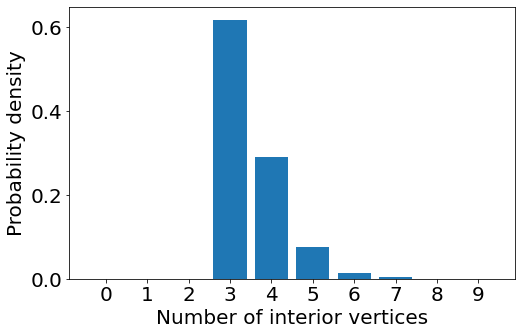

In [6]:
# Plot histogram of number of vertices
plt.figure(  figsize=(8,5) )
plt.bar(np.arange(0,10),N_CP_hist[0:10]/np.sum(N_CP_hist),align='center',tick_label=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Number of interior vertices',fontsize=20)
plt.ylabel('Probability density',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example2_number_vertices.pdf',bbox_inches='tight')

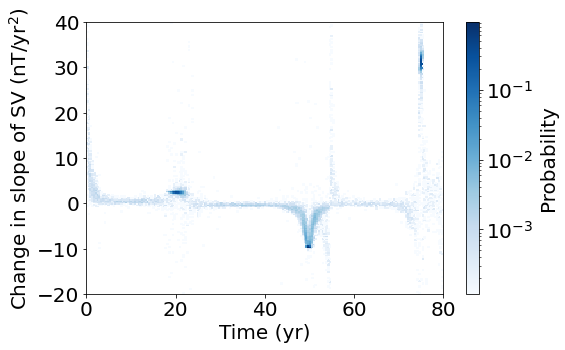

In [7]:
import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(8,5))
counts, xedges, yedges, im = ax.hist2d(jerk_data[0:size_jerk_data,0], jerk_data[0:size_jerk_data,1], bins=(200,200), range=[[0,80], [-20,40]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
cb = fig.colorbar(im, ax=ax)
cb.set_label("Probability", labelpad=6, size=20)
cb.ax.tick_params(labelsize=20)
        
#ax.scatter([20,40,60],[4.5, -15.5,  7.5],marker='o',color='None', s=300, edgecolors='r',lw=2)

ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_xlabel('Time (yr)',fontsize=20)
ax.set_ylabel('Change in slope of SV (nT/yr$^2$)',fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('example2_2Dhist.pdf',bbox_inches='tight')

In [8]:
# Find maximum probability:
indices = np.unravel_index(np.argmax(counts),counts.shape)
print('Maximum occurs in time bin {0:3.3f} : {1:3.3f}'.format(xedges[indices[0]],xedges[indices[0]+1])  )
print('Maximum occurs in slope bin {0:3.3f} : {1:3.3f}'.format(yedges[indices[1]],yedges[indices[1]+1])  )


Maximum occurs in time bin 49.600 : 50.000
Maximum occurs in slope bin -9.800 : -9.500


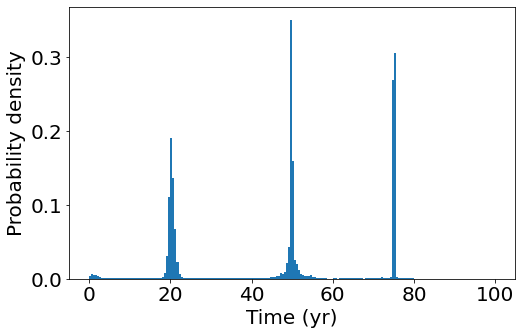

In [9]:
fig, ax = plt.subplots( figsize=(8,5))
marginal_counts, marginal_xedges, marginal_im = ax.hist( jerk_data[0:size_jerk_data,0], bins=200, range=[0,100], density=True)
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Probability density', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('example2_changepoint_hist.pdf',bbox_inches='tight')

In [10]:
from find_jerks import find_jerks

In [11]:
data_timing = jerk_data[0:size_jerk_data,0]
data_amplitude = jerk_data[0:size_jerk_data,1]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
time_range = [TIMES_MIN,TIMES_MAX]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, time_range, \
                        amplitude_range=[-50,50],number_amplitude_bins=400)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with amplitude {4:f} with timing min/max of {2:f}, {3:f}'.\
            format(index,jerk[0], jerk[2], jerk[3], jerk[1]))
print('Bin width in jerk amplitude is ', (20--20)/400)    

3 jerks found
Jerk 0 at time 20.250000 with amplitude 2.625000 with timing min/max of 20.000000, 21.000000
Jerk 1 at time 49.750000 with amplitude -9.625000 with timing min/max of 49.500000, 50.000000
Jerk 2 at time 75.250000 with amplitude 31.625000 with timing min/max of 74.500000, 75.500000
Bin width in jerk amplitude is  0.1


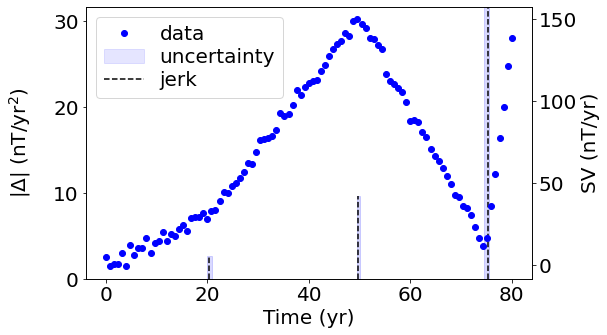

In [12]:
fig, ax = plt.subplots( figsize=(8,5))
axb = ax.twinx()

axb.plot(TIMES,Y,'bo', label='data')

#axb.legend(loc='lower right',fontsize=20, labelspacing=0.2)
axb.tick_params(axis='both', which='major', labelsize=20)
axb.set_ylabel('SV (nT/yr)',fontsize=20)

#plot jerks
ymin = 0
ymax = max(abs(jerk[1]) for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    
#add to the legend, but only once!
ax.fill_betweenx([],[], alpha=0.1, color='blue', label='uncertainty')
ax.vlines([], [], [], colors='k',label='jerk',linestyles='dashed')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_ylabel('$|\Delta|$ (nT/yr$^2$)', fontsize=20,labelpad=20)
ax.set_xlabel('Time (yr)',fontsize=20)
ax.plot([],[],'bo', label='data')
ax.legend(loc='upper left',fontsize=20, labelspacing=0.2)
plt.savefig('example2_data_with_jerks.pdf',bbox_inches='tight')




### Make movie of cumulative sampling, using the thinned chain.
#### First, rerun the MCMC code with increased thinning, 100 frames is enough.

In [13]:
import os
import sys
sys.path.append( os.path.abspath('..') )
sys.path.append( os.path.abspath('.') )
from jerks import jerks
import numpy as np

# Define parameters for method:

Y_MIN = Y.min()
Y_MAX = Y.max()

TIMES_MIN = 0.0
TIMES_MAX = 100.0
K_MIN = 0
K_MAX = 100
relative_sigmas = np.array([0.08, 0.02, 0.08])

sigmas = np.array([ (Y.max() - Y.min())*relative_sigmas[0],\
                (TIMES_MAX - TIMES_MIN)*relative_sigmas[1],\
                   (Y.max() - Y.min())*relative_sigmas[2]],dtype = float)




NBINS = 1000
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 1000000+burn_in
THIN = 10000

# define spaces for outputs
Acceptance_rates=np.zeros(4)
AV = np.zeros(discretise_size,dtype=float)
SUP = np.zeros(discretise_size,dtype=float)
INF = np.zeros(discretise_size,dtype=float)
MEDIAN = np.zeros(discretise_size,dtype=float)
MODE = np.zeros(discretise_size,dtype=float)
MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
N_CP_hist = np.zeros( K_MAX, dtype=int)
# jerks:
jerk_data = np.zeros( (K_MAX *(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

#saved history for animations
jerk_history = np.zeros( ((NSAMPLE-burn_in)//THIN,2), dtype=int)
model_history = np.zeros( (discretise_size, (NSAMPLE-burn_in)//THIN),dtype=float)

(Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, 
MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data, \
model_history, jerk_history) = jerks.rjmcmc(
 sigmas=sigmas, burn_in=burn_in, 
 nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=Y, delta_y=delta_Y, 
 y_min=Y_MIN, y_max=Y_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
 k_max=K_MAX, discretise_size=discretise_size,
 thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)

print('Acceptance rates should ideally be 10-40%')
print(Acceptance_rates)

Acceptance rates should ideally be 10-40%
[32.19580078 24.47470093  9.32204437  9.35370636]


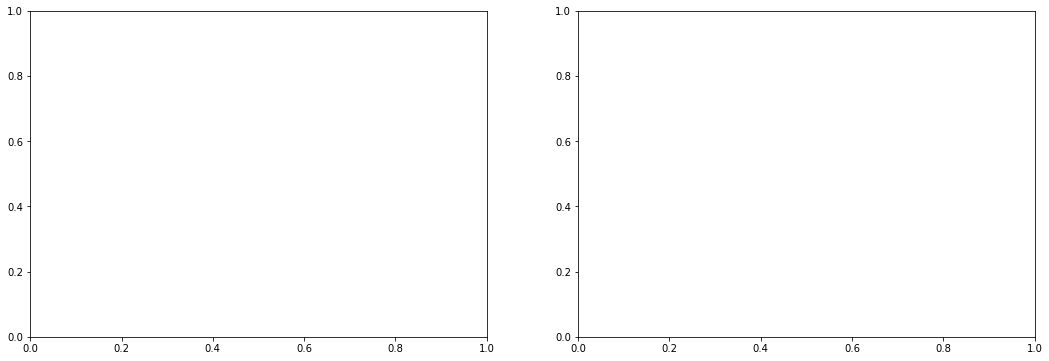

In [24]:
%matplotlib inline
from matplotlib.animation import FuncAnimation
 
def plot_movie_frame( frame_index ):
    time_model_history = np.linspace(0,100,discretise_size,endpoint=True)
    ax1.clear()
    ax2.clear()
# plot the current frame in red:
    ax1.plot( time_model_history, model_history[:,frame_index],'r', linewidth=3,zorder=3)
    ax2.scatter( jerk_data[jerk_history[frame_index,0]-1:jerk_history[frame_index,1]-1+1,0], \
                 jerk_data[jerk_history[frame_index,0]-1:jerk_history[frame_index,1]-1+1,1], \
                 s= 25, color='red',zorder=3)
# plot previous frames in light red
    if frame_index > 0:
        ax1.plot( time_model_history, model_history[:,:frame_index],\
                  linewidth=1, color='lightsalmon',zorder=1)
        ax2.scatter( jerk_data[0:jerk_history[frame_index,0]-1,0], \
                     jerk_data[0:jerk_history[frame_index,0]-1,1], 5, color='lightsalmon',zorder=1 )

    ax1.scatter(TIMES,Y,10,color='black', zorder=2)
    ax1.set_xlim(0,80)
    ax2.set_xlim(0,80)
    ax2.set_ylim(-20,35)
    ax1.set_ylim(-100,150)
    ax1.set_xlabel('Time',fontsize=20)
    ax2.set_xlabel('Time',fontsize=20)
    ax1.set_ylabel('SV (nT/yr)',fontsize=20)
    ax2.set_ylabel('$\Delta$ (nT/yr$^2$)',fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=20)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

    fig.suptitle("Markov chain after {0:d} iterations".format((frame_index+1)*THIN), fontsize=22)
    
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6) )
 
anim = FuncAnimation(fig, plot_movie_frame, frames=100,
                    interval=500, repeat=False)



In [25]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
anim.save("test_multiple_sampling.gif", dpi=300,
         writer=PillowWriter(fps=10))

<Figure size 432x288 with 0 Axes>

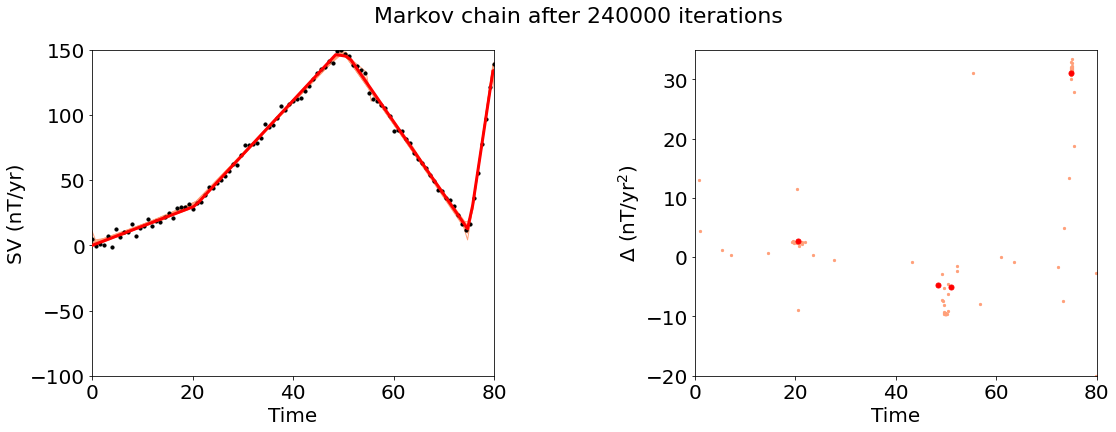

In [27]:
# show single frame:
frame = 23
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,6) )
plot_movie_frame(frame)